## Learning from Imbalanced Datasets
This is the notebook for the impplementation of the project.

### Importing libraries
The required libraries for this project are given below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, silhouette_score, pairwise_distances
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

### Helper functions
For the project I have developed some helper functions which will be used further in the notebook. These functions will make the work easy and effective.

In [2]:
def read_dataset(file_path, columns_opt=None, header_opt=None, delim_white=False):
    dataset = pd.read_csv(file_path, header=header_opt, names=columns_opt, delim_whitespace=delim_white)
    display(dataset.head())
    return dataset

def dataset_insights(dataset, label_column):
    display(dataset.describe())
    unique_classes = dataset[label_column].unique()
    print(f"\nClasses in dataset: {unique_classes}\n")
    print("Data Rows for each class:")
    for label in unique_classes:
        total_rows = len(dataset[dataset[label_column] == label])
        print(f"{total_rows} data rows for {label} class.")
    
def preprocess_dataset(dataset, label_column):
    dataset_columns = dataset.columns
    for column in dataset_columns:
        if column != label_column:
            dataset[column] = dataset[column] / dataset[column].max()
    
    display(dataset)
    return dataset

def plot_classes_chart(dataset, label_column):
    class_labels = dataset[label_column].unique()
    class_rows = {}
    for label in class_labels:
        class_rows[label] = len(dataset[dataset[label_column] == label])

    class_names = [name for name, _ in class_rows.items()]
    class_count = [count for _, count in class_rows.items()]

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.barh(class_names, class_count, color="darkorange")

    plt.xlabel("Number of Data Rows per Class")
    plt.ylabel("Class Name")
    ax.set_title("Number of Data for each Class in the Dataset")
    ax.set_yticks([0, 1, 2])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color="grey", linestyle='-', linewidth=0.25, alpha=0.85)    

In [3]:
def getClassWithHighestDataRows(dataset, label_column):
    class_rows = {}
    for label in dataset[label_column].unique():
        class_rows[label] = len(dataset[dataset[label_column] == label])
    
    sorted_class_rows = sorted(class_rows.items(), key=lambda x:x[1], reverse=True)
    
    return sorted_class_rows[0]


def getDataRowsLength(class_with_most_data, imbalance_percentage, remaining_classes):
    new_dataset_total_rows = round((class_with_most_data[1] / imbalance_percentage) * 100)
    remaining_classes_percentage = 100 - imbalance_percentage
    remaining_classes_data = round(((new_dataset_total_rows / 100) * remaining_classes_percentage) / remaining_classes ) 
    
    return remaining_classes_data


def saveDataFrame(dataset, new_dataset, last_index, limit=None):
    dataset_columns = dataset.columns
    curr_index = last_index
    for _, data in dataset.iterrows():
        if curr_index <= (limit + last_index):
            for column in dataset_columns:
                new_dataset.at[curr_index, column] = data[column]

            curr_index += 1
     
    return new_dataset, curr_index


def createSubset(dataset, class_with_most_data, remaining_classes_rows, remaining_classes, label_column):
    new_dataset = pd.DataFrame(columns=dataset.columns)
    index = 0
    most_class_data = dataset[dataset[label_column] == class_with_most_data[0]]
    new_dataset, index = saveDataFrame(dataset, most_class_data, last_index=index, limit=class_with_most_data[1])
    
    for label in remaining_classes:
        dataset_class_data = dataset[dataset[label_column] == label]
        new_dataset, index = saveDataFrame(dataset_class_data, new_dataset, last_index=index, limit=remaining_classes_rows)
    
    return new_dataset

def getImbalanceSubset(dataset, label_column, imbalance_percentage):
    class_with_most_data = getClassWithHighestDataRows(dataset, label_column)
    remaining_classes = list(dataset[label_column].unique())
    remaining_classes.remove(class_with_most_data[0])
    
    remaining_classes_rows = getDataRowsLength(class_with_most_data, imbalance_percentage, len(remaining_classes))
    imbalance_dataset = createSubset(dataset, class_with_most_data, remaining_classes_rows, remaining_classes, label_column)
    
    dataset_insights(imbalance_dataset, label_column=label_column)
    
    return imbalance_dataset

In [4]:
def getFeaturesLabels(dataset, label_column):
    return dataset.drop(label_column, axis=1), dataset[label_column]


def trainAndTestModelWithKFolds(classifier, cross_validator, features, labels):
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    
    for train_index, test_index in cross_validator.split(features, labels):
        classifier.fit(features.iloc[train_index], labels.iloc[train_index])

        actual_classes = np.append(actual_classes, labels.iloc[test_index])
        predicted_classes = np.append(predicted_classes, classifier.predict(features.iloc[test_index]))
    
    return actual_classes, predicted_classes

def computeAndPlotConfusionMatrix(actual_classes, predicted_classes, labels):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=labels)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8,8))
    cm_display.plot(cmap=plt.cm.Blues, ax=ax)

In [5]:
def plotKData(metrics_info, technique=""):

    k_values = [k for k, _ in metrics_info.items()]
    k_scores = [score for _, score in metrics_info.items()]

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(k_values, k_scores, color="orangered", marker='o')

    plt.xlabel("No of Clusters")
    plt.ylabel("Score")
    ax.set_title(f"{technique} for finding best value of K")
    ax.set_xticks(k_values)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color="grey", linestyle='-', linewidth=0.25, alpha=0.85)

In [6]:
def applyTechniquesOnKFoldsOfData(features, labels):
    cross_validator = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
    unseen_fold_train_indexes = np.empty([0], dtype=int)
    unseen_fold_test_indexes = np.empty([0], dtype=int)
    train_fold_indexes = np.empty([0], dtype=int)
    test_fold_indexes = np.empty([0], dtype=int)
    
    kFold = 0
    for train_index, test_index in cross_validator.split(features, labels):
        if kFold == 0:
            unseen_fold_train_indexes = np.append(unseen_fold_train_indexes, train_index)
            unseen_fold_test_indexes = np.append(unseen_fold_test_indexes, test_index)
        else:
            train_fold_indexes = np.append(train_fold_indexes, train_index)
            test_fold_indexes = np.append(test_fold_indexes, test_index)
        
        kFold += 1
        
    
    return train_fold_indexes, test_fold_indexes, unseen_fold_train_indexes, unseen_fold_test_indexes
    
def identifyNumberOfClusters(features):
    elbow_method_k = sorted(elbowMethodResult(features).items(), key=lambda x: x[1],reverse=False)
    
    return elbow_method_k[4]

def elbowMethodResult(features):
    k_metrices = {}
    for k in range(2, 11):
        kmean_classifier = KMeans(n_clusters=k).fit(features)
        k_metrices[k] = kmean_classifier.inertia_
    
    plotKData(k_metrices, technique="Elbow Method")
        

def avgSilhouteMethodResult(features):
    k_metrices = {}
    for k in range(2, 11):
        kmean_classifier = KMeans(n_clusters=k)
        kmean_cluster = kmean_classifier.fit_predict(features)
        avg_score = silhouette_score(features, kmean_cluster)
        
        k_metrices[k] = avg_score
    
    plotKData(k_metrices, technique="Silhoute Method")

def trainRandomForestClassifier(features, labels):
    classifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)
    return classifier.fit(features, labels)

def kMeanClusteringImplementation(k_clusters, features):
    kmean_classifier = KMeans(n_clusters=k_clusters).fit(features)
    
    return kmean_classifier

In [7]:
def getpointsClusterInformation(kMeansClf, features, labels, distance_threshold):
    clusters_closets = pairwise_distances(kMeansClf.cluster_centers_, features)
    cluster_details = []
    
    for cluster in range(kMeansClf.n_clusters):
        cluster_detailed_info = {}
        data_indexes_in_cluster = []
        index = 0
        cluster_detailed_info["K"] = cluster + 1
        cluster_detailed_info["centroid"] = kMeansClf.cluster_centers_[cluster]

        for point in clusters_closets[cluster]:
            if point <= distance_threshold:
                data_indexes_in_cluster.append(index)
            index += 1

        #Unique Classes in cluster
        labels_data = labels.iloc[data_indexes_in_cluster]
        unique_classes = np.unique(labels_data)
        cluster_detailed_info["total_classes"] = unique_classes
        try:
            if len(unique_classes) > 1:
                labels_info = {}
                for label in unique_classes:
                    labels_info[label] = len(labels_data[labels_data == label])
                labels_info = sorted(labels_info.items(), key=lambda x:x[1])

                cluster_detailed_info["minority_class"] = labels_info[0][0]
                cluster_detailed_info["minority_class_count"] = labels_info[0][1]

                features_data = features.iloc[data_indexes_in_cluster]

                classifier = trainRandomForestClassifier(features_data, labels_data)
                cluster_detailed_info["classifier"] = classifier

            else:
                cluster_detailed_info["minority_class"] = unique_classes[0]
                cluster_detailed_info["minority_class_count"] = len(labels_data)
                cluster_detailed_info["classifier"] = None
        
        except Exception:
            pass

        cluster_details.append(cluster_detailed_info)
        
    return cluster_details

In [8]:
def getUnseenFoldPrediction(kMeansClf, unseen_fold_features, distance_threshold):
    predicted_labels = []
    for feature in unseen_fold_features.to_numpy():
        cluster_distances = pairwise_distances(kMeansClf.cluster_centers_, feature.reshape(1,-1))
        close_clusters = {}
        for cluster in range(len(cluster_distances)):
            if cluster_distances[cluster] <= distance_threshold:
                close_clusters[cluster] = cluster_distances[cluster]

        try:
            choosen_cluster = sorted(close_clusters.items(), key=lambda x:x[1])[0]
            if len(cluster_details[choosen_cluster[0]]["total_classes"]) > 1:
                predicted_labels.append(cluster_details[choosen_cluster[0]]["classifier"].predict(feature.reshape(1,-1)))
            else:
                predicted_labels.append(cluster_details[choosen_cluster[0]]["minority_class"])
        except Exception:
            predicted_labels.append(cluster_details[0]["minority_class"])
    
    return predicted_labels

def getCleanPredictions(predictions):
    cleaned_pred = []
    for pred in predictions:
        try:
            if type(pred) == list or len(pred) > 0:
                cleaned_pred.append(pred[0])
            else:
                cleaned_pred.append(pred)
        except:
            cleaned_pred.append(pred)
            
    return cleaned_pred

## Iris Dataset
First of all I will work Iris Dataset.

### Loading Dataset

In [9]:
column_names = ["sepalLengthCm", "sepalWidthCm", "petalLengthCm", "pepalWidthCm", "class"]
iris_dataset = read_dataset(file_path="iris.data", columns_opt=column_names)

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### Dataset Insights

In [10]:
dataset_insights(iris_dataset, label_column="class")

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
50 data rows for Iris-versicolor class.
50 data rows for Iris-virginica class.


### Dataset Preprocessing

In [11]:
iris_dataset = preprocess_dataset(iris_dataset, label_column="class")

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm,class
0,0.645570,0.795455,0.202899,0.08,Iris-setosa
1,0.620253,0.681818,0.202899,0.08,Iris-setosa
2,0.594937,0.727273,0.188406,0.08,Iris-setosa
3,0.582278,0.704545,0.217391,0.08,Iris-setosa
4,0.632911,0.818182,0.202899,0.08,Iris-setosa
...,...,...,...,...,...
145,0.848101,0.681818,0.753623,0.92,Iris-virginica
146,0.797468,0.568182,0.724638,0.76,Iris-virginica
147,0.822785,0.681818,0.753623,0.80,Iris-virginica
148,0.784810,0.772727,0.782609,0.92,Iris-virginica


### Visualizing the number of classes in the dataset 

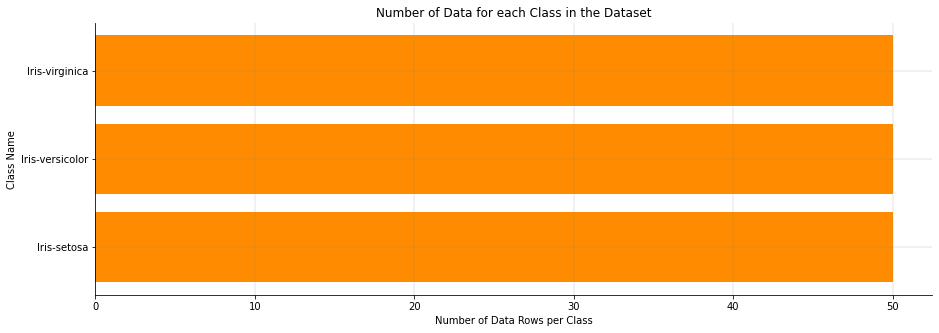

In [12]:
plot_classes_chart(iris_dataset, label_column="class")

### Low Imbalanced Dataset

In [13]:
iris_low_imb_dataset = getImbalanceSubset(iris_dataset, label_column="class", imbalance_percentage=65)

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,79.000000,79.000000,79.000000,79.000000
mean,0.692838,0.729862,0.397358,0.307342
std,0.102028,0.105035,0.256052,0.296201
min,0.544304,0.454545,0.144928,0.040000
25%,0.620253,0.681818,0.202899,0.080000
50%,0.658228,0.727273,0.231884,0.120000
75%,0.753165,0.795455,0.659420,0.560000
max,0.962025,1.000000,0.956522,1.000000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
15 data rows for Iris-versicolor class.
14 data rows for Iris-virginica class.


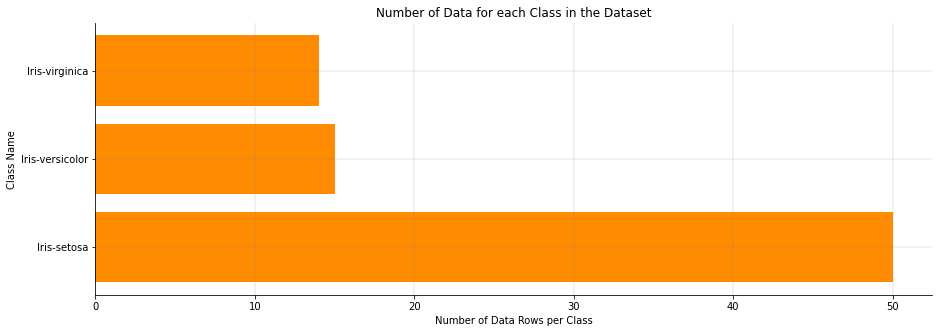

In [14]:
plot_classes_chart(iris_low_imb_dataset, label_column="class")

### Mid Imbalance Dataset

In [15]:
iris_mid_imb_dataset = getImbalanceSubset(iris_dataset, label_column="class", imbalance_percentage=75)

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,69.000000,69.000000,69.000000,69.000000
mean,0.681710,0.744071,0.355598,0.254493
std,0.099819,0.097571,0.243648,0.270248
min,0.544304,0.522727,0.144928,0.040000
25%,0.620253,0.681818,0.202899,0.080000
50%,0.645570,0.727273,0.217391,0.120000
75%,0.721519,0.795455,0.579710,0.520000
max,0.962025,1.000000,0.956522,1.000000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
10 data rows for Iris-versicolor class.
9 data rows for Iris-virginica class.


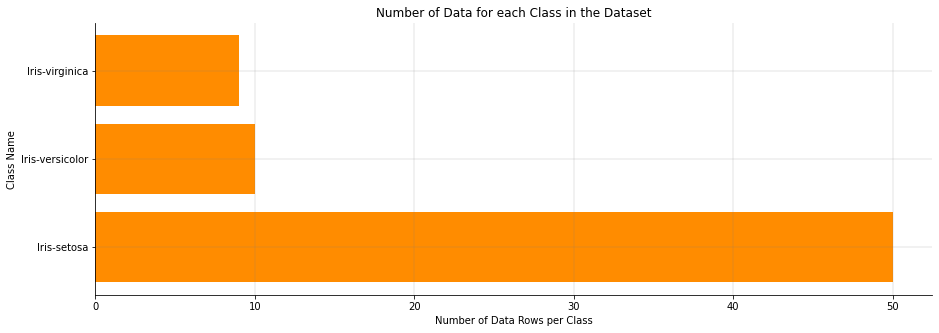

In [16]:
plot_classes_chart(iris_mid_imb_dataset, label_column="class")

### High Imbalanced Dataset

In [17]:
iris_high_imb_dataset = getImbalanceSubset(iris_dataset, label_column="class", imbalance_percentage=90)

,sepalLengthCm,sepalWidthCm,petalLengthCm,pepalWidthCm
count,59.000000,59.000000,59.000000,59.000000
mean,0.662090,0.761941,0.291329,0.187119
std,0.083446,0.091140,0.192996,0.224369
min,0.544304,0.522727,0.144928,0.040000
25%,0.607595,0.704545,0.202899,0.080000
50%,0.645570,0.772727,0.217391,0.080000
75%,0.683544,0.806818,0.239130,0.160000
max,0.898734,1.000000,0.869565,1.000000



Classes in dataset: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Data Rows for each class:
50 data rows for Iris-setosa class.
5 data rows for Iris-versicolor class.
4 data rows for Iris-virginica class.


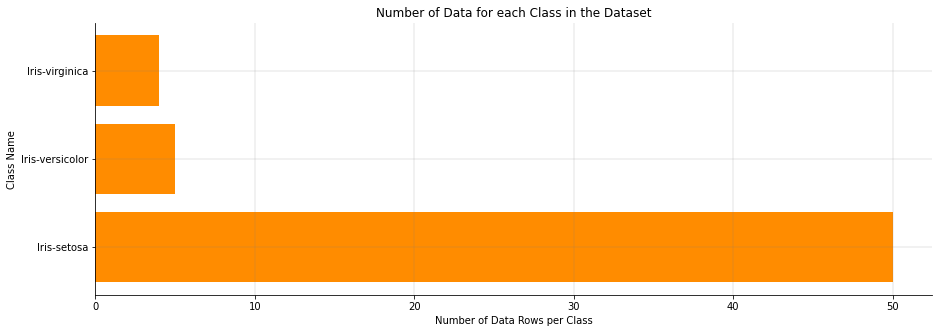

In [18]:
plot_classes_chart(iris_high_imb_dataset, label_column="class")

### Applying Cross validation on the Datasets

In [19]:
cross_validator = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
randomForestClassifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)

### Training Balanced Dataset

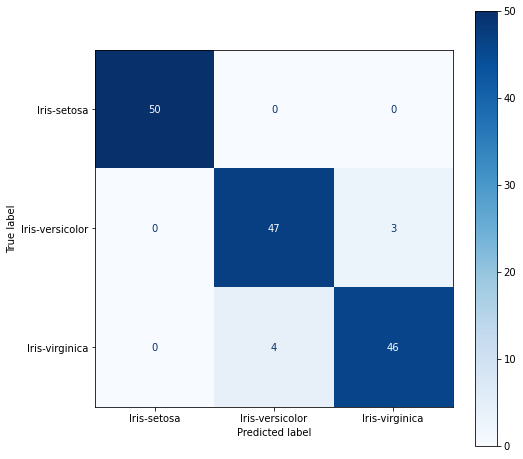

In [20]:
features, labels = getFeaturesLabels(iris_dataset, label_column="class")
test_labels, pred_labels = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features, labels)

computeAndPlotConfusionMatrix(test_labels, pred_labels, labels=iris_dataset["class"].unique())

### Training Low Imbalanced Dataset

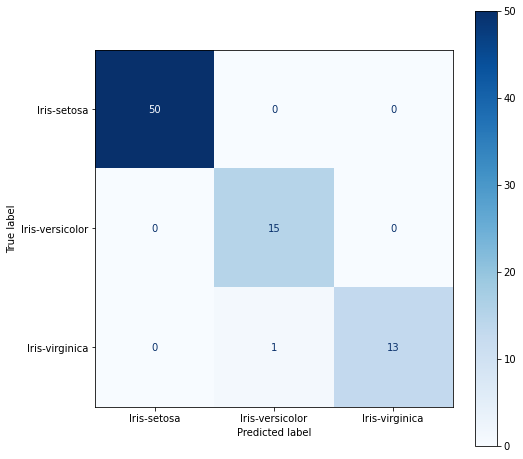

In [21]:
features_low_imb, labels_low_imb = getFeaturesLabels(iris_low_imb_dataset, label_column="class")
test_labels_low_imb, pred_labels_low_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_low_imb, labels_low_imb)

computeAndPlotConfusionMatrix(test_labels_low_imb, pred_labels_low_imb, labels=iris_dataset["class"].unique())

### Training Mid Imbalanced Dataset

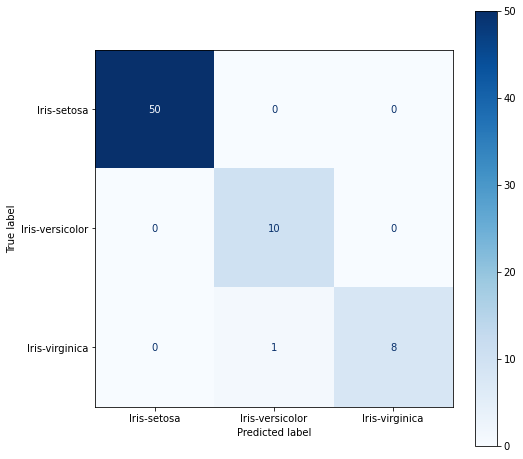

In [22]:
features_mid_imb, labels_mid_imb = getFeaturesLabels(iris_mid_imb_dataset, label_column="class")
test_labels_mid_imb, pred_labels_mid_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_mid_imb, labels_mid_imb)

computeAndPlotConfusionMatrix(test_labels_mid_imb, pred_labels_mid_imb, labels=iris_dataset["class"].unique())

### Training High Imbalanced Dataset

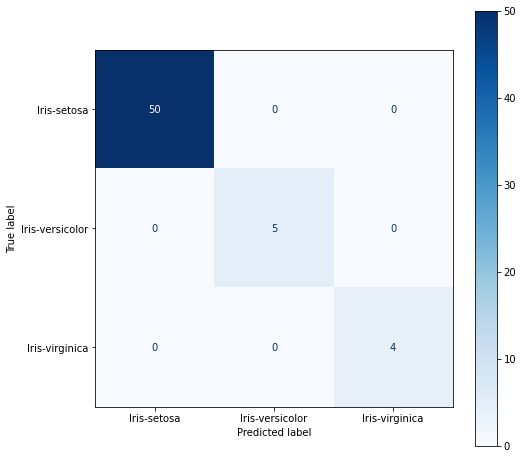

In [23]:
features_high_imb, labels_high_imb = getFeaturesLabels(iris_high_imb_dataset, label_column="class")
test_labels_high_imb, pred_labels_high_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_high_imb, labels_high_imb)

computeAndPlotConfusionMatrix(test_labels_high_imb, pred_labels_high_imb, labels=iris_dataset["class"].unique())

## Low Imbalance Iris Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [24]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_low_imb, labels_low_imb)

### Seperating Features and Labels

In [25]:
train_features = features_low_imb.iloc[train_fold_indexes]
train_labels = labels_low_imb.iloc[train_fold_indexes]

unseen_fold_features = features_low_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_low_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

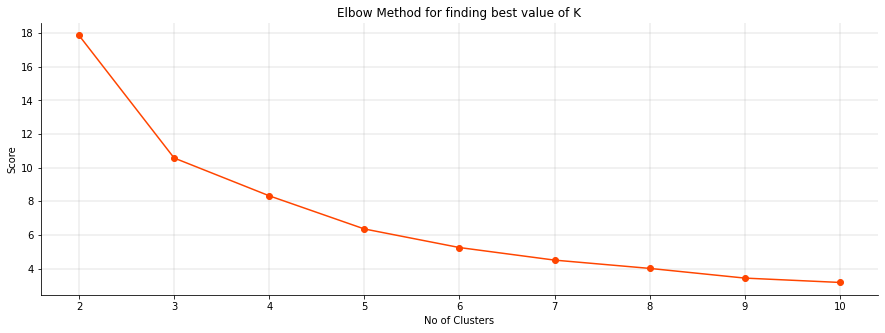

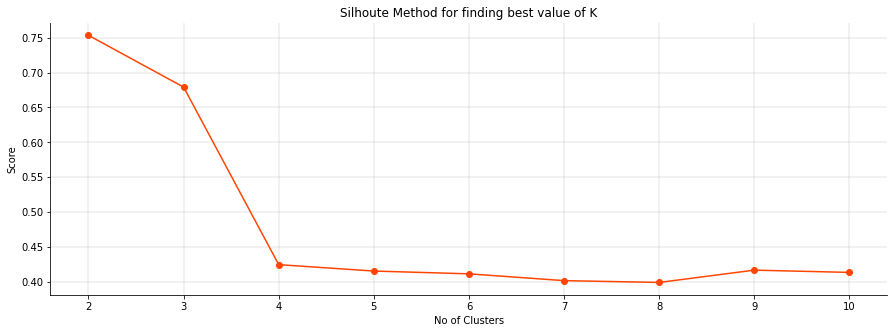

In [26]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [27]:
kmean_classifier_iris = KMeans(n_clusters=4)
iris_cluster_labels = kmean_classifier_iris.fit(train_features)

In [28]:
cluster_details = getpointsClusterInformation(kmean_classifier_iris, train_features, train_labels, distance_threshold=0.43)
cluster_details

[{'K': 1,
  'centroid': array([0.83893912, 0.67034632, 0.82650104, 0.8232381 ]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-versicolor',
  'minority_class_count': 89,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 2,
  'centroid': array([0.66386018, 0.83673895, 0.21499801, 0.11522936]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
  'minority_class_count': 405,
  'classifier': None},
 {'K': 3,
  'centroid': array([0.75744888, 0.63111888, 0.62686734, 0.54492308]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-virginica',
  'minority_class_count': 88,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 4,
  'centroid': array([0.59920125, 0.70782693, 0.20863365, 0.07657754]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
 

### Predicting Classes from Unseen Data fold

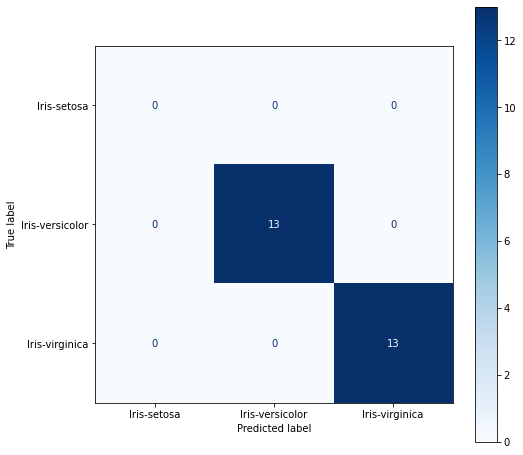

In [29]:
predictions = getUnseenFoldPrediction(kmean_classifier_iris, unseen_fold_features, 0.43)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=iris_dataset["class"].unique())

## Mid Imbalance Iris Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [30]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_mid_imb, labels_mid_imb)

### Seperating Features and Labels

In [31]:
train_features = features_mid_imb.iloc[train_fold_indexes]
train_labels = labels_mid_imb.iloc[train_fold_indexes]

unseen_fold_features = features_mid_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_mid_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

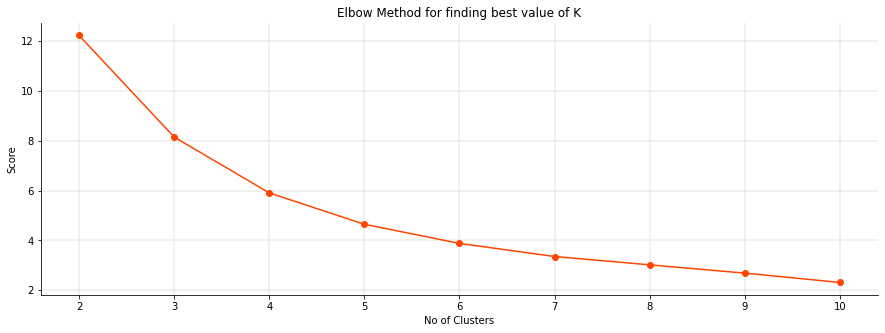

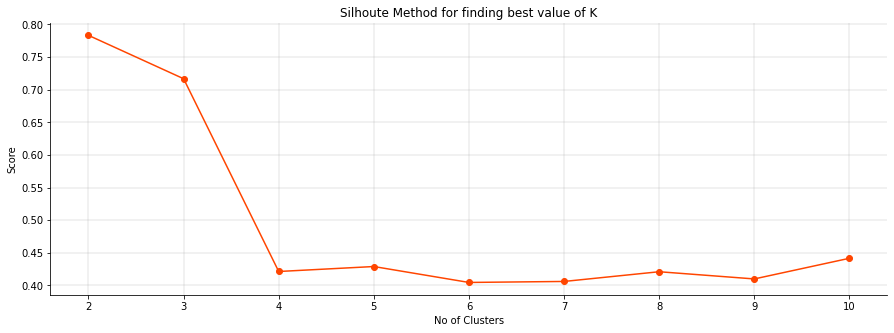

In [32]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [33]:
kmean_classifier_iris = KMeans(n_clusters=4)
iris_cluster_labels = kmean_classifier_iris.fit(train_features)

In [34]:
cluster_details = getpointsClusterInformation(kmean_classifier_iris, train_features, train_labels, distance_threshold=0.43)
cluster_details

[{'K': 1,
  'centroid': array([0.84771178, 0.66223776, 0.85306577, 0.81107692]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-versicolor',
  'minority_class_count': 65,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 2,
  'centroid': array([0.66276465, 0.83447305, 0.21508272, 0.1139823 ]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
  'minority_class_count': 405,
  'classifier': None},
 {'K': 3,
  'centroid': array([0.78025885, 0.6557712 , 0.645986  , 0.56359551]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-virginica',
  'minority_class_count': 57,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 4,
  'centroid': array([0.59769465, 0.70492636, 0.20824225, 0.07642458]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
 

### Predicting Classes from Unseen Data fold

## High Imbalance Iris Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [35]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_high_imb, labels_high_imb)

### Seperating Features and Labels

In [36]:
train_features = features_high_imb.iloc[train_fold_indexes]
train_labels = labels_high_imb.iloc[train_fold_indexes]

unseen_fold_features = features_high_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_high_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

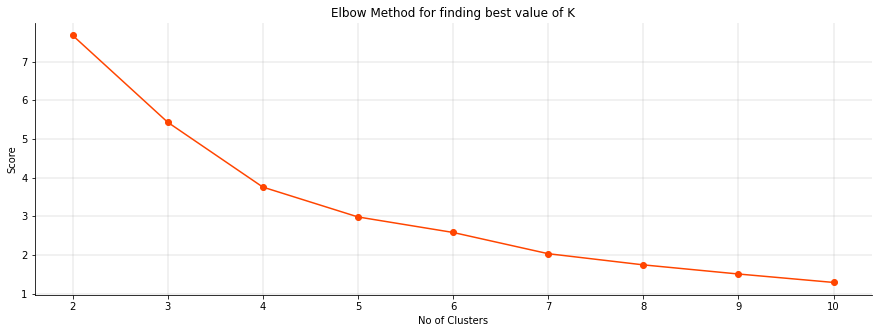

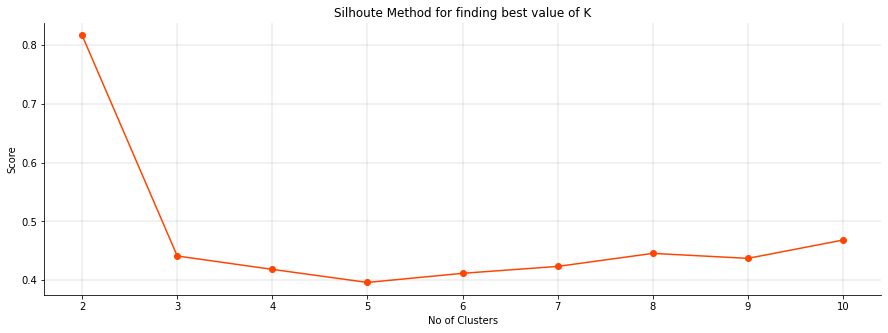

In [37]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [38]:
kmean_classifier_iris = KMeans(n_clusters=3)
iris_cluster_labels = kmean_classifier_iris.fit(train_features)

In [39]:
cluster_details = getpointsClusterInformation(kmean_classifier_iris, train_features, train_labels, distance_threshold=0.45)
cluster_details

[{'K': 1,
  'centroid': array([0.66455696, 0.83917749, 0.21490683, 0.11657143]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
  'minority_class_count': 405,
  'classifier': None},
 {'K': 2,
  'centroid': array([0.82070401, 0.67963885, 0.73079214, 0.68328767]),
  'total_classes': array(['Iris-versicolor', 'Iris-virginica'], dtype=object),
  'minority_class': 'Iris-virginica',
  'minority_class_count': 32,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 3,
  'centroid': array([0.60110354, 0.71048951, 0.20899294, 0.07671795]),
  'total_classes': array(['Iris-setosa'], dtype=object),
  'minority_class': 'Iris-setosa',
  'minority_class_count': 405,
  'classifier': None}]

### Predicting Classes from Unseen Data fold

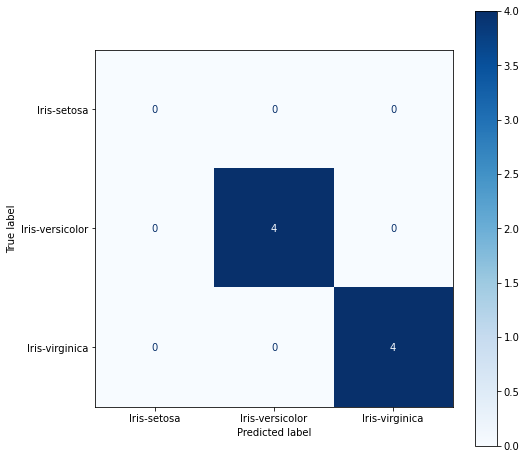

In [40]:
predictions = getUnseenFoldPrediction(kmean_classifier_iris, unseen_fold_features, 0.45)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=iris_dataset["class"].unique())

## Yeast Dataset

### Loading Dataset

In [41]:
column_names = ["Sequence Name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "class"]
yeast_dataset = read_dataset(file_path="yeast.data", columns_opt=column_names, delim_white=True)

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [42]:
yeast_dataset = yeast_dataset[(yeast_dataset["class"] == "CYT") | (yeast_dataset["class"] == "NUC")]
yeast_dataset

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
5,AATC_YEAST,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
7,BAF1_YEAST,0.48,0.45,0.59,0.20,0.5,0.0,0.58,0.34,NUC
9,ABP1_YEAST,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
10,ACE1_YEAST,0.43,0.39,0.54,0.21,0.5,0.0,0.53,0.27,NUC
...,...,...,...,...,...,...,...,...,...,...
1477,R29A_YEAST,0.38,0.32,0.64,0.41,0.5,0.0,0.44,0.11,CYT
1478,R29B_YEAST,0.38,0.40,0.66,0.35,0.5,0.0,0.43,0.11,CYT
1480,ZIP1_YEAST,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1482,ZUO1_YEAST,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


### Dataset Insights

In [43]:
dataset_insights(yeast_dataset, label_column="class")

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000
mean,0.467119,0.463072,0.532489,0.227702,0.503924,0.000561,0.496850,0.293038
std,0.109985,0.101246,0.061761,0.112601,0.044144,0.016741,0.062455,0.122272
min,0.110000,0.130000,0.320000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.390000,0.400000,0.500000,0.160000,0.500000,0.000000,0.470000,0.220000
50%,0.470000,0.460000,0.530000,0.200000,0.500000,0.000000,0.510000,0.250000
75%,0.540000,0.530000,0.570000,0.270000,0.500000,0.000000,0.530000,0.330000
max,0.900000,0.830000,1.000000,1.000000,1.000000,0.500000,0.730000,1.000000



Classes in dataset: ['NUC' 'CYT']

Data Rows for each class:
429 data rows for NUC class.
463 data rows for CYT class.


### Dataset Preprocessing

In [44]:
yeast_dataset = yeast_dataset.drop("Sequence Name", axis=1)
yeast_dataset = preprocess_dataset(yeast_dataset, label_column="class")

,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
3,0.644444,0.530120,0.57,0.13,0.5,0.0,0.739726,0.22,NUC
5,0.566667,0.481928,0.56,0.17,0.5,1.0,0.671233,0.22,CYT
7,0.533333,0.542169,0.59,0.20,0.5,0.0,0.794521,0.34,NUC
9,0.444444,0.469880,0.60,0.15,0.5,0.0,0.794521,0.30,CYT
10,0.477778,0.469880,0.54,0.21,0.5,0.0,0.726027,0.27,NUC
...,...,...,...,...,...,...,...,...,...
1477,0.422222,0.385542,0.64,0.41,0.5,0.0,0.602740,0.11,CYT
1478,0.422222,0.481928,0.66,0.35,0.5,0.0,0.589041,0.11,CYT
1480,0.522222,0.518072,0.61,0.40,0.5,0.0,0.657534,0.47,NUC
1482,0.477778,0.481928,0.60,0.16,0.5,0.0,0.726027,0.39,NUC


### Visualizing the number of classes in the dataset 

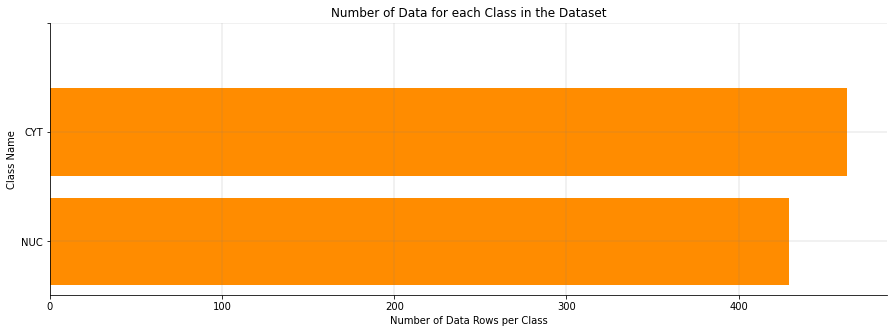

In [45]:
plot_classes_chart(yeast_dataset, label_column="class")

### Low Imbalanced Dataset

In [46]:
yeast_low_imb_dataset = getImbalanceSubset(yeast_dataset, label_column="class", imbalance_percentage=65)

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000
mean,0.518807,0.554704,0.532336,0.227776,0.505561,0.001011,0.680070,0.288119
std,0.126107,0.120704,0.059331,0.114653,0.052464,0.031798,0.088286,0.113608
min,0.122222,0.192771,0.370000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.433333,0.469880,0.500000,0.160000,0.500000,0.000000,0.643836,0.220000
50%,0.522222,0.554217,0.530000,0.200000,0.500000,0.000000,0.698630,0.250000
75%,0.600000,0.638554,0.570000,0.270000,0.500000,0.000000,0.726027,0.320000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Classes in dataset: ['NUC' 'CYT']

Data Rows for each class:
485 data rows for NUC class.
504 data rows for CYT class.


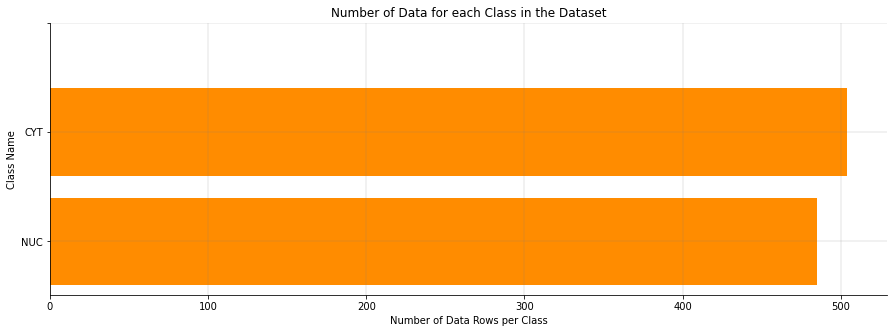

In [47]:
plot_classes_chart(yeast_low_imb_dataset, label_column="class")

### Mid Imbalance Dataset

In [48]:
yeast_mid_imb_dataset = getImbalanceSubset(yeast_dataset, label_column="class", imbalance_percentage=75)

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,0.520199,0.556943,0.532461,0.227704,0.505519,0.001104,0.680426,0.283212
std,0.123185,0.119384,0.060030,0.114452,0.052268,0.033223,0.089610,0.110125
min,0.122222,0.240964,0.370000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.433333,0.469880,0.500000,0.160000,0.500000,0.000000,0.643836,0.220000
50%,0.522222,0.554217,0.530000,0.195000,0.500000,0.000000,0.698630,0.250000
75%,0.608333,0.638554,0.570000,0.270000,0.500000,0.000000,0.726027,0.310000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Classes in dataset: ['NUC' 'CYT']

Data Rows for each class:
390 data rows for NUC class.
516 data rows for CYT class.


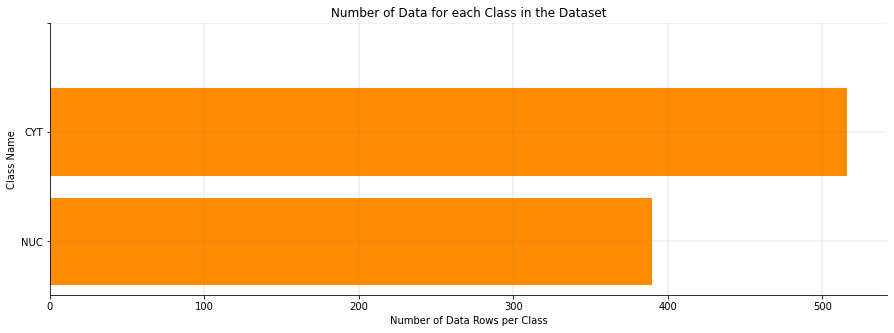

In [49]:
plot_classes_chart(yeast_mid_imb_dataset, label_column="class")

### High Imbalanced Dataset

In [50]:
yeast_high_imb_dataset = getImbalanceSubset(yeast_dataset, label_column="class", imbalance_percentage=90)

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000,818.000000
mean,0.523716,0.558032,0.532005,0.227751,0.505501,0.001222,0.683290,0.277787
std,0.122437,0.116405,0.060622,0.114486,0.052189,0.034964,0.085815,0.108215
min,0.122222,0.240964,0.370000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.444444,0.481928,0.500000,0.160000,0.500000,0.000000,0.657534,0.220000
50%,0.522222,0.554217,0.530000,0.190000,0.500000,0.000000,0.698630,0.220000
75%,0.611111,0.626506,0.560000,0.270000,0.500000,0.000000,0.726027,0.310000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Classes in dataset: ['NUC' 'CYT']

Data Rows for each class:
287 data rows for NUC class.
531 data rows for CYT class.


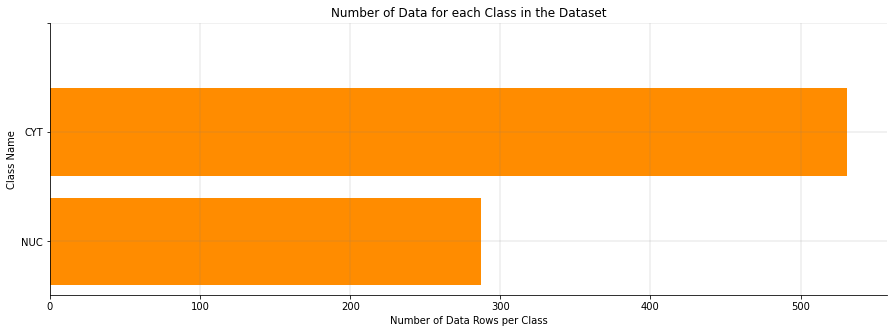

In [51]:
plot_classes_chart(yeast_high_imb_dataset, label_column="class")

### Applying Cross validation on the Datasets

In [52]:
cross_validator = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
randomForestClassifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)

### Training Balanced Dataset

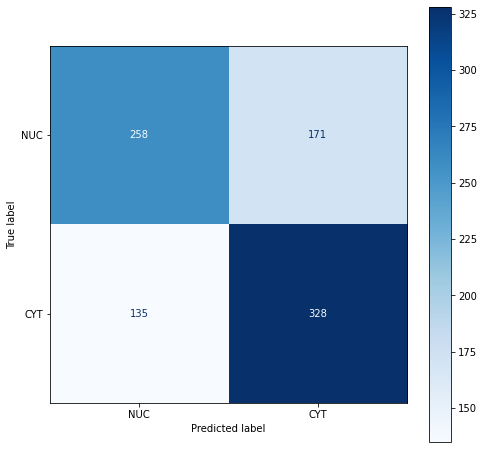

In [53]:
features, labels = getFeaturesLabels(yeast_dataset, label_column="class")
test_labels, pred_labels = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features, labels)

computeAndPlotConfusionMatrix(test_labels, pred_labels, labels=yeast_dataset["class"].unique())

### Training Low Imbalanced Dataset

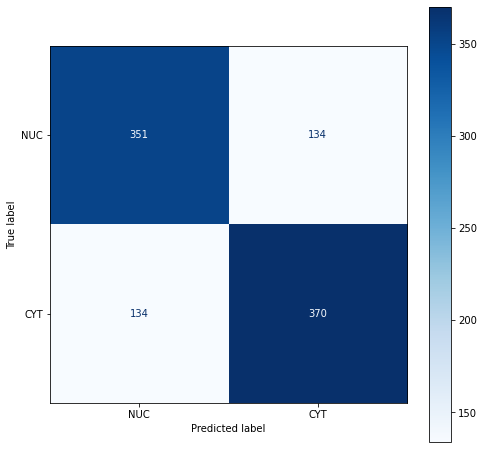

In [54]:
features_low_imb, labels_low_imb = getFeaturesLabels(yeast_low_imb_dataset, label_column="class")
test_labels_low_imb, pred_labels_low_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_low_imb, labels_low_imb)

computeAndPlotConfusionMatrix(test_labels_low_imb, pred_labels_low_imb, labels=yeast_dataset["class"].unique())

### Training Mid Imbalanced Dataset

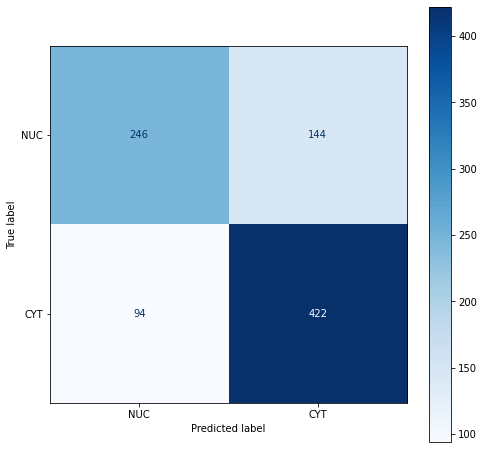

In [55]:
features_mid_imb, labels_mid_imb = getFeaturesLabels(yeast_mid_imb_dataset, label_column="class")
test_labels_mid_imb, pred_labels_mid_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_mid_imb, labels_mid_imb)

computeAndPlotConfusionMatrix(test_labels_mid_imb, pred_labels_mid_imb, labels=yeast_dataset["class"].unique())

### Training High Imbalanced Dataset

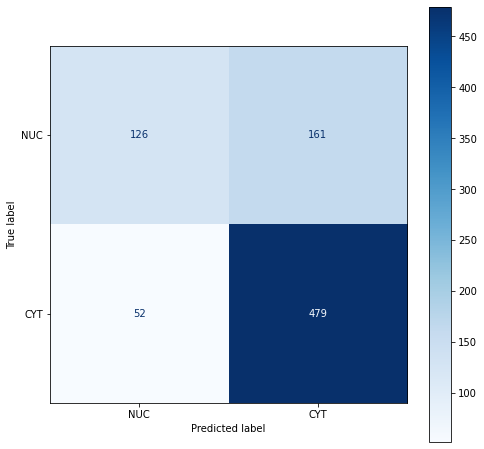

In [56]:
features_high_imb, labels_high_imb = getFeaturesLabels(yeast_high_imb_dataset, label_column="class")
test_labels_high_imb, pred_labels_high_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_high_imb, labels_high_imb)

computeAndPlotConfusionMatrix(test_labels_high_imb, pred_labels_high_imb, labels=yeast_dataset["class"].unique())

## Low Imbalance Yeast Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [57]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_low_imb, labels_low_imb)

### Seperating Features and Labels

In [58]:
train_features = features_low_imb.iloc[train_fold_indexes]
train_labels = labels_low_imb.iloc[train_fold_indexes]

unseen_fold_features = features_low_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_low_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

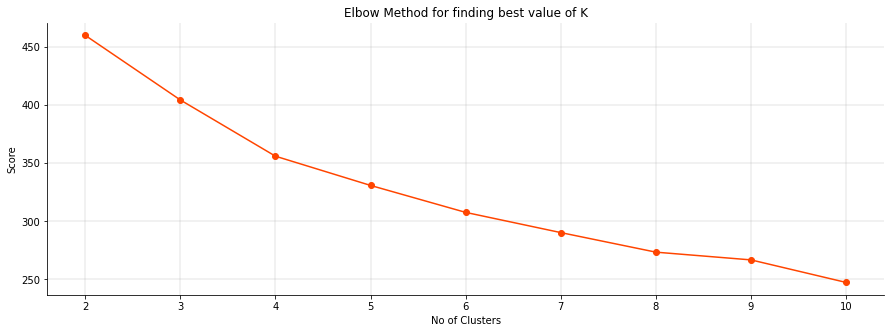

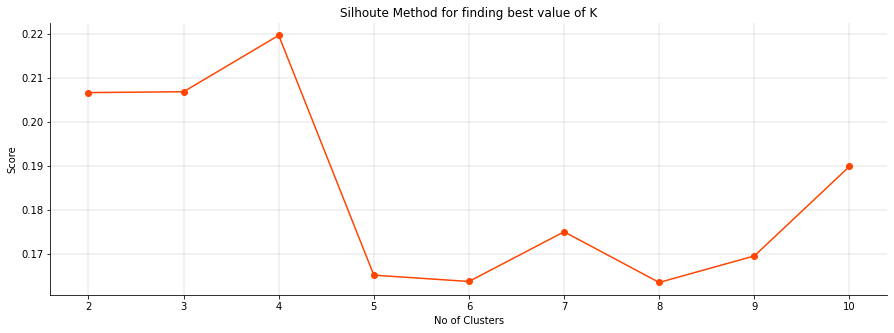

In [59]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [60]:
kmean_classifier_yeast = KMeans(n_clusters=5)
yeast_cluster_labels = kmean_classifier_yeast.fit(train_features)

In [61]:
cluster_details = getpointsClusterInformation(kmean_classifier_yeast, train_features, train_labels, distance_threshold=0.16)
cluster_details

[{'K': 1,
  'centroid': array([0.50008213, 0.56206664, 0.53789159, 0.1894157 , 0.50563182,
         0.00281591, 0.69361068, 0.24519887]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'NUC',
  'minority_class_count': 747,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 2,
  'centroid': array([5.16653595e-01, 5.28986534e-01, 5.46105882e-01, 4.74129412e-01,
         5.04705882e-01, 1.51788304e-18, 6.46913779e-01, 2.51894118e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'CYT',
  'minority_class_count': 50,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 3,
  'centroid': array([4.72954579e-01, 5.39505559e-01, 5.14181092e-01, 2.26644474e-01,
         5.00000000e-01, 1.51788304e-18, 6.90750233e-01, 5.47203728e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'CYT',
  'minority_class_count': 24,
  'classifier': RandomForestClassifier(m

### Predicting Classes from Unseen Data fold

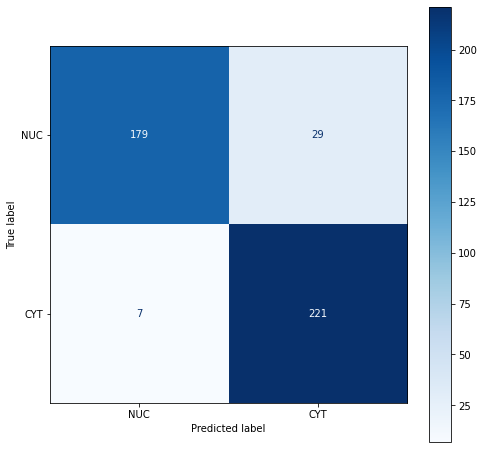

In [62]:
predictions = getUnseenFoldPrediction(kmean_classifier_yeast, unseen_fold_features, 0.16)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=yeast_dataset["class"].unique())

## Mid Imbalance Yeast Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [63]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_mid_imb, labels_mid_imb)

### Seperating Features and Labels

In [64]:
train_features = features_mid_imb.iloc[train_fold_indexes]
train_labels = labels_mid_imb.iloc[train_fold_indexes]

unseen_fold_features = features_mid_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_mid_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

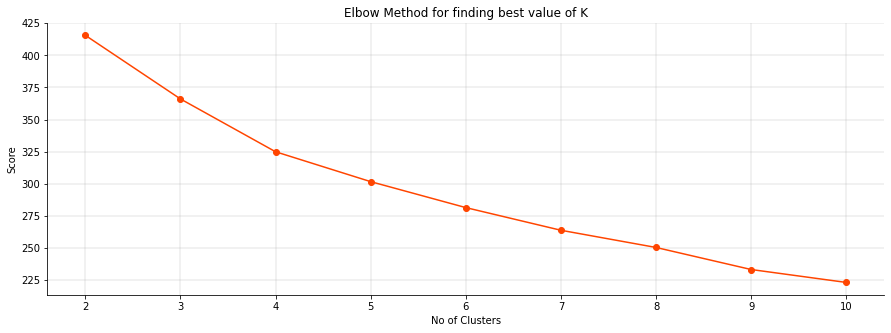

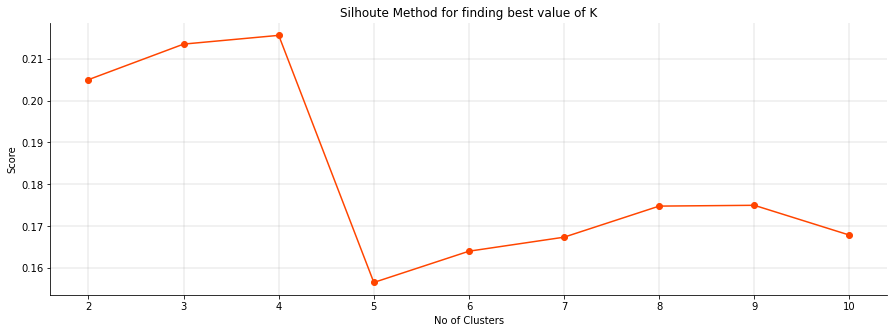

In [65]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [66]:
kmean_classifier_yeast = KMeans(n_clusters=5)
yeast_cluster_labels = kmean_classifier_yeast.fit(train_features)

In [67]:
cluster_details = getpointsClusterInformation(kmean_classifier_yeast, train_features, train_labels,distance_threshold=0.16)
cluster_details

[{'K': 1,
  'centroid': array([ 6.07445524e-01,  7.01660846e-01,  5.15277301e-01,  1.97895941e-01,
          5.06861063e-01, -4.11996826e-18,  7.00094770e-01,  2.74568325e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'NUC',
  'minority_class_count': 461,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 2,
  'centroid': array([ 3.87611111e-01,  4.68460509e-01,  5.44922222e-01,  1.97000000e-01,
          5.02222222e-01, -3.46944695e-18,  6.61933029e-01,  2.54305556e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'NUC',
  'minority_class_count': 511,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 3,
  'centroid': array([ 5.24100772e-01,  5.23772679e-01,  5.49357798e-01,  4.81231979e-01,
          5.05242464e-01, -3.68628739e-18,  6.47282716e-01,  2.54036697e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'CYT',
  'minority_c

### Predicting Classes from Unseen Data fold

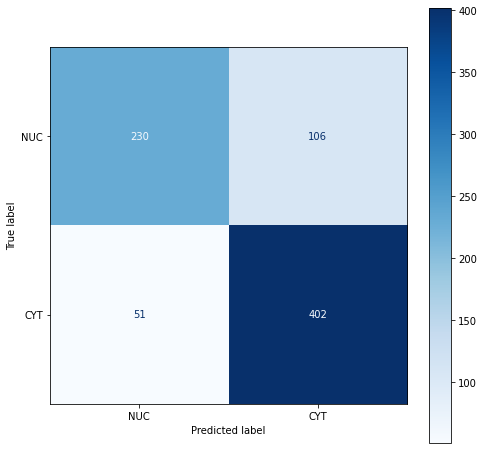

In [68]:
predictions = getUnseenFoldPrediction(kmean_classifier_yeast, unseen_fold_features, 0.45)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=yeast_dataset["class"].unique())

## High Imbalance Yeast Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [69]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_high_imb, labels_high_imb)

### Seperating Features and Labels

In [70]:
train_features = features_high_imb.iloc[train_fold_indexes]
train_labels = labels_high_imb.iloc[train_fold_indexes]

unseen_fold_features = features_high_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_high_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

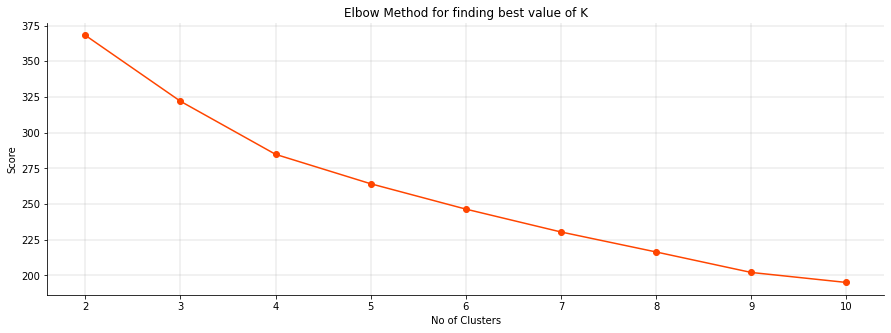

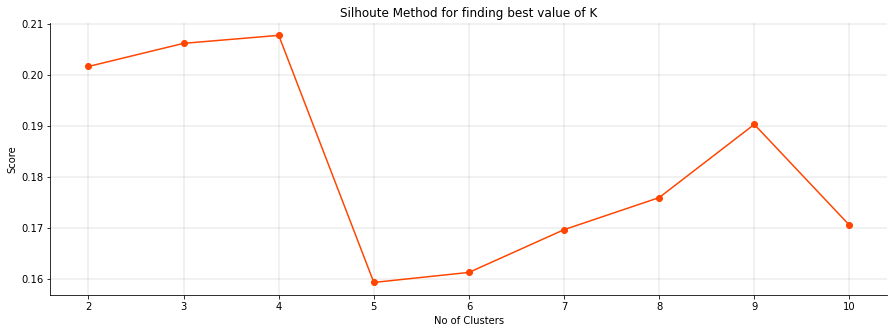

In [71]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [72]:
kmean_classifier_yeast = KMeans(n_clusters=5)
yeast_cluster_labels = kmean_classifier_yeast.fit(train_features)

In [73]:
cluster_details = getpointsClusterInformation(kmean_classifier_yeast, train_features, train_labels, distance_threshold=0.16)
cluster_details

[{'K': 1,
  'centroid': array([0.56619014, 0.54301282, 0.531431  , 0.19523567, 0.50700637,
         0.00339703, 0.69018992, 0.24662845]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'NUC',
  'minority_class_count': 468,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 2,
  'centroid': array([3.89794452e-01, 4.81054879e-01, 5.45381630e-01, 1.94560155e-01,
         5.02910737e-01, 4.55364912e-18, 6.69301246e-01, 2.48880983e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'NUC',
  'minority_class_count': 373,
  'classifier': RandomForestClassifier(max_depth=6, n_estimators=10)},
 {'K': 3,
  'centroid': array([6.24882517e-01, 7.06481841e-01, 5.12265233e-01, 1.96917563e-01,
         5.05734767e-01, 4.55364912e-18, 7.01939412e-01, 2.64580645e-01]),
  'total_classes': array(['CYT', 'NUC'], dtype=object),
  'minority_class': 'NUC',
  'minority_class_count': 301,
  'classifier': RandomForestClassifier

### Predicting Classes from Unseen Data fold

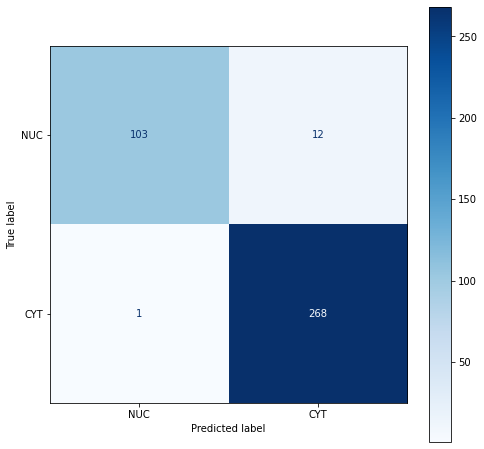

In [74]:
predictions = getUnseenFoldPrediction(kmean_classifier_yeast, unseen_fold_features, 0.16)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=yeast_dataset["class"].unique())

## Wine Dataset

### Loading Dataset

In [75]:
column_names = ["class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
wine_dataset = read_dataset(file_path="wine.data", columns_opt=column_names)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Dataset Insights

In [76]:
dataset_insights(wine_dataset, label_column="class")

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000



Classes in dataset: [1 2 3]

Data Rows for each class:
59 data rows for 1 class.
71 data rows for 2 class.
48 data rows for 3 class.


### Dataset Preprocessing

In [77]:
wine_dataset = preprocess_dataset(wine_dataset, label_column="class")

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,0.959541,0.294828,0.752322,0.520000,0.783951,0.721649,0.602362,0.424242,0.639665,0.433846,0.608187,0.9800,0.633929
1,1,0.890088,0.306897,0.662539,0.373333,0.617284,0.682990,0.543307,0.393939,0.357542,0.336923,0.614035,0.8500,0.625000
2,1,0.887390,0.406897,0.826625,0.620000,0.623457,0.721649,0.637795,0.454545,0.784916,0.436923,0.602339,0.7925,0.705357
3,1,0.968982,0.336207,0.773994,0.560000,0.697531,0.992268,0.687008,0.363636,0.608939,0.600000,0.502924,0.8625,0.880952
4,1,0.892785,0.446552,0.888545,0.700000,0.728395,0.721649,0.529528,0.590909,0.508380,0.332308,0.608187,0.7325,0.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,0.924477,0.974138,0.758514,0.683333,0.586420,0.432990,0.120079,0.787879,0.296089,0.592308,0.374269,0.4350,0.440476
174,3,0.903574,0.674138,0.767802,0.766667,0.629630,0.463918,0.147638,0.651515,0.393855,0.561538,0.409357,0.3900,0.446429
175,3,0.894808,0.737931,0.699690,0.666667,0.740741,0.409794,0.135827,0.651515,0.377095,0.784615,0.345029,0.3900,0.497024
176,3,0.888065,0.446552,0.733746,0.666667,0.740741,0.425258,0.133858,0.803030,0.407821,0.715385,0.350877,0.4050,0.500000


### Visualizing the number of classes in the dataset 

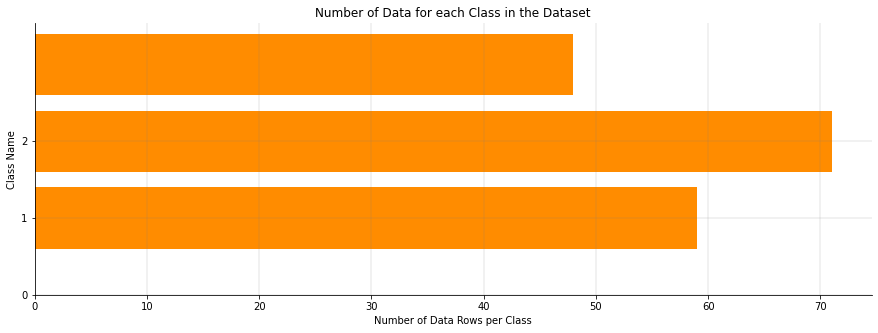

In [78]:
plot_classes_chart(wine_dataset, label_column="class")

### Low Imbalanced Dataset

In [79]:
wine_low_imb_dataset = getImbalanceSubset(wine_dataset, label_column="class", imbalance_percentage=65)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1.546154,0.898423,0.382003,0.744677,0.609231,0.629962,0.652339,0.484464,0.507692,0.465814,0.391172,0.589996,0.706423,0.542120
std,0.748244,0.055381,0.178350,0.083218,0.112912,0.079328,0.153705,0.192230,0.168891,0.162557,0.125887,0.113817,0.165770,0.211207
min,1.000000,0.743763,0.127586,0.421053,0.353333,0.481481,0.252577,0.066929,0.212121,0.114525,0.098462,0.315789,0.317500,0.203571
25%,1.000000,0.864295,0.277586,0.698142,0.533333,0.575617,0.545103,0.394193,0.393939,0.357542,0.304808,0.520468,0.631250,0.357143
50%,1.000000,0.909305,0.311207,0.743034,0.600000,0.623457,0.676546,0.529528,0.454545,0.480447,0.392308,0.608187,0.725000,0.546131
75%,2.000000,0.936952,0.437069,0.804180,0.676667,0.685185,0.760309,0.619587,0.606061,0.553073,0.461538,0.659357,0.832500,0.707589
max,3.000000,1.000000,1.000000,1.000000,0.950000,0.932099,1.000000,1.000000,0.954545,0.826816,0.723077,1.000000,1.000000,1.000000



Classes in dataset: [2. 1. 3.]

Data Rows for each class:
31 data rows for 2.0 class.
79 data rows for 1.0 class.
20 data rows for 3.0 class.


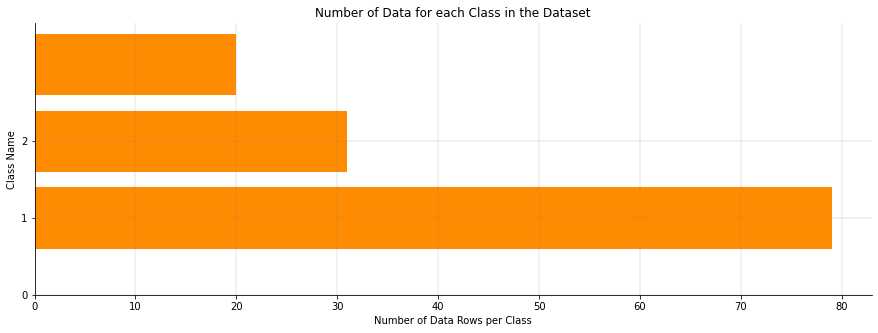

In [80]:
plot_classes_chart(wine_low_imb_dataset, label_column="class")

### Mid Imbalance Dataset

In [81]:
wine_mid_imb_dataset = getImbalanceSubset(wine_dataset, label_column="class", imbalance_percentage=75)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1.546154,0.888210,0.362931,0.734032,0.614410,0.621605,0.654223,0.488053,0.506177,0.474280,0.359349,0.595574,0.724885,0.512990
std,0.671820,0.057997,0.161121,0.090058,0.109234,0.079671,0.147716,0.174025,0.172534,0.163240,0.121698,0.102393,0.152339,0.212491
min,1.000000,0.743763,0.127586,0.421053,0.353333,0.481481,0.283505,0.092520,0.212121,0.114525,0.098462,0.385965,0.317500,0.185714
25%,1.000000,0.837492,0.274569,0.678793,0.540833,0.557099,0.567010,0.399606,0.393939,0.377095,0.260385,0.520468,0.678750,0.333631
50%,1.000000,0.892785,0.304310,0.736842,0.601667,0.617284,0.670103,0.527559,0.454545,0.486034,0.365385,0.608187,0.736250,0.498512
75%,2.000000,0.934592,0.406897,0.792570,0.682500,0.666667,0.760309,0.602362,0.590909,0.561453,0.436923,0.654971,0.836250,0.681548
max,3.000000,1.000000,1.000000,1.000000,0.950000,0.932099,1.000000,1.000000,1.000000,1.000000,0.684615,1.000000,1.000000,1.000000



Classes in dataset: [2. 1. 3.]

Data Rows for each class:
45 data rows for 2.0 class.
72 data rows for 1.0 class.
13 data rows for 3.0 class.


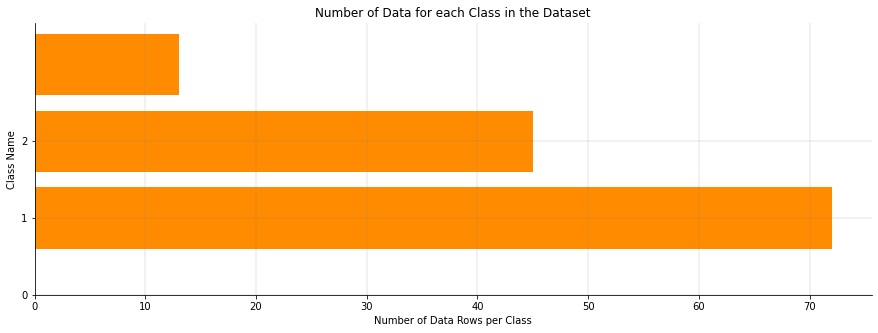

In [82]:
plot_classes_chart(wine_mid_imb_dataset, label_column="class")

### High Imbalanced Dataset

In [83]:
wine_high_imb_dataset = getImbalanceSubset(wine_dataset, label_column="class", imbalance_percentage=90)

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1.546154,0.876586,0.344828,0.731246,0.621974,0.618708,0.648929,0.489552,0.500350,0.487258,0.334361,0.606910,0.729923,0.482276
std,0.572111,0.059410,0.148987,0.089800,0.109684,0.092190,0.146320,0.154083,0.168070,0.155518,0.126784,0.101901,0.140893,0.210017
min,1.000000,0.743763,0.127586,0.421053,0.353333,0.432099,0.283505,0.112205,0.212121,0.114525,0.098462,0.385965,0.322500,0.172619
25%,1.000000,0.828726,0.260776,0.681115,0.554167,0.543210,0.553479,0.384843,0.393939,0.391061,0.223846,0.538012,0.680625,0.295685
50%,2.000000,0.879973,0.298276,0.730650,0.616667,0.608025,0.670103,0.520669,0.454545,0.476257,0.332308,0.608187,0.740000,0.437500
75%,2.000000,0.927006,0.366810,0.787926,0.692500,0.666667,0.746134,0.596457,0.590909,0.565642,0.430769,0.660819,0.831250,0.640625
max,3.000000,1.000000,1.000000,1.000000,0.950000,1.000000,1.000000,1.000000,1.000000,1.000000,0.684615,1.000000,1.000000,1.000000



Classes in dataset: [2. 1. 3.]

Data Rows for each class:
61 data rows for 2.0 class.
64 data rows for 1.0 class.
5 data rows for 3.0 class.


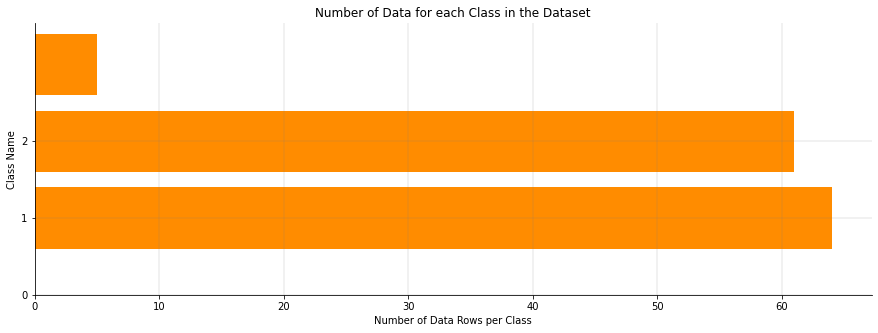

In [84]:
plot_classes_chart(wine_high_imb_dataset, label_column="class")

### Applying Cross validation on the Datasets

In [85]:
cross_validator = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
randomForestClassifier = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=6)

### Training Balanced Dataset

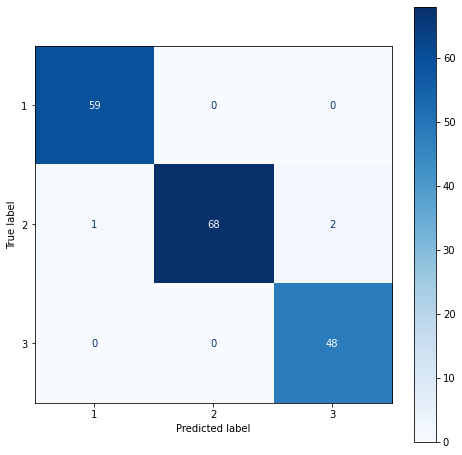

In [86]:
features, labels = getFeaturesLabels(wine_dataset, label_column="class")
test_labels, pred_labels = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features, labels)

computeAndPlotConfusionMatrix(test_labels, pred_labels, labels=wine_dataset["class"].unique())

### Training Low Imbalanced Dataset

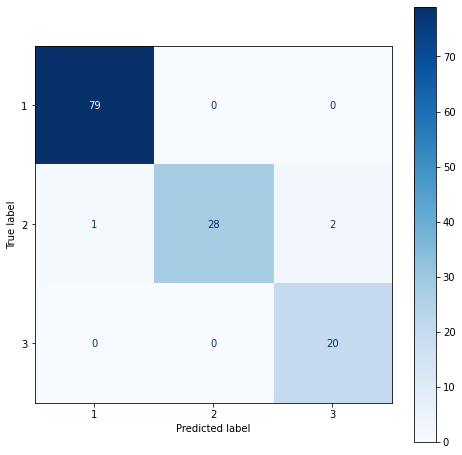

In [87]:
features_low_imb, labels_low_imb = getFeaturesLabels(wine_low_imb_dataset, label_column="class")
test_labels_low_imb, pred_labels_low_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_low_imb, labels_low_imb)

computeAndPlotConfusionMatrix(test_labels_low_imb, pred_labels_low_imb, labels=wine_dataset["class"].unique())

### Training Mid Imbalanced Dataset

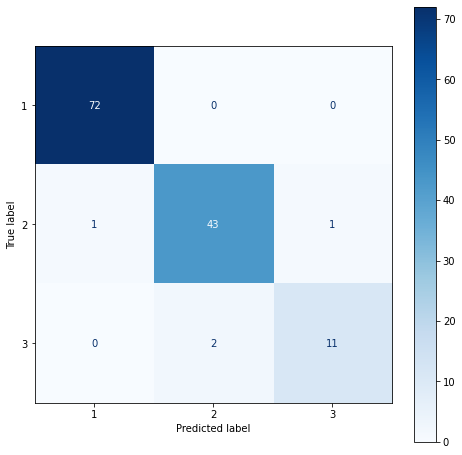

In [88]:
features_mid_imb, labels_mid_imb = getFeaturesLabels(wine_mid_imb_dataset, label_column="class")
test_labels_mid_imb, pred_labels_mid_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_mid_imb, labels_mid_imb)

computeAndPlotConfusionMatrix(test_labels_mid_imb, pred_labels_mid_imb, labels=wine_dataset["class"].unique())

### Training High Imbalanced Dataset

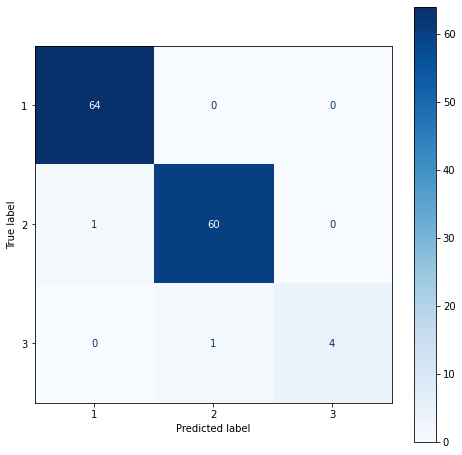

In [89]:
features_high_imb, labels_high_imb = getFeaturesLabels(wine_high_imb_dataset, label_column="class")
test_labels_high_imb, pred_labels_high_imb = trainAndTestModelWithKFolds(randomForestClassifier, cross_validator, features_high_imb, labels_high_imb)

computeAndPlotConfusionMatrix(test_labels_high_imb, pred_labels_high_imb, labels=wine_dataset["class"].unique())

## Low Imbalance Wine Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [90]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_low_imb, labels_low_imb)

### Seperating Features and Labels

In [91]:
train_features = features_low_imb.iloc[train_fold_indexes]
train_labels = labels_low_imb.iloc[train_fold_indexes]

unseen_fold_features = features_low_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_low_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

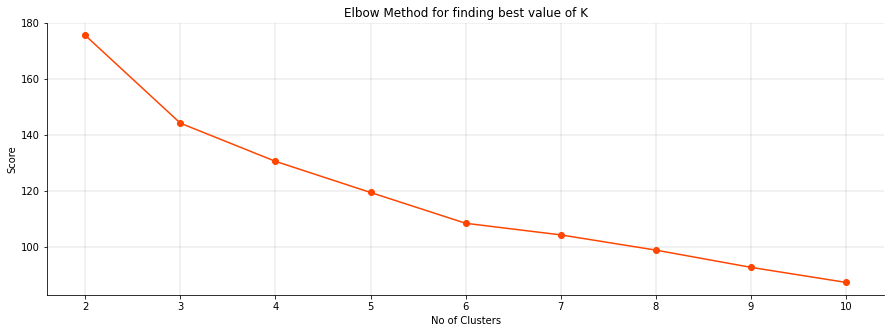

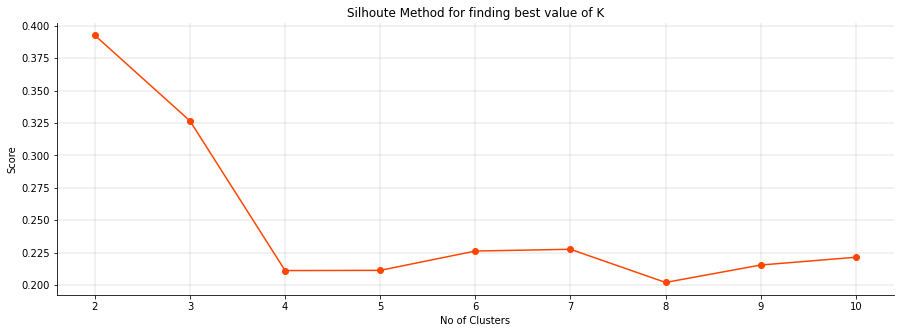

In [92]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [93]:
kmean_classifier_wine = KMeans(n_clusters=4)
wine_cluster_labels = kmean_classifier_wine.fit(train_features)

In [94]:
cluster_details = getpointsClusterInformation(kmean_classifier_wine, train_features, train_labels, distance_threshold=0.22)
cluster_details

[{'K': 1,
  'centroid': array([0.83375617, 0.38164903, 0.752276  , 0.72447195, 0.58803936,
         0.64637134, 0.49334412, 0.560006  , 0.4745008 , 0.25176314,
         0.60569741, 0.74579208, 0.29417138]),
  'total_classes': array([2.]),
  'minority_class': 2.0,
  'minority_class_count': 8,
  'classifier': None},
 {'K': 2,
  'centroid': array([0.92576366, 0.34652183, 0.73071279, 0.54310212, 0.65330407,
         0.69574221, 0.54927518, 0.40514976, 0.49611683, 0.38170076,
         0.60899841, 0.82962428, 0.60466557]),
  'total_classes': array([1.]),
  'minority_class': 1.0,
  'minority_class_count': 56,
  'classifier': None},
 {'K': 3,
  'centroid': array([0.86478038, 0.5213173 , 0.72243496, 0.66211988, 0.5972493 ,
         0.43340794, 0.17908206, 0.67417597, 0.2500245 , 0.38691296,
         0.4672925 , 0.44781798, 0.36668233]),
  'total_classes': array([], dtype=float64)},
 {'K': 4,
  'centroid': array([0.93885212, 0.31198182, 0.77461971, 0.56469314, 0.65795338,
         0.78298411, 0.

### Predicting Classes from Unseen Data fold

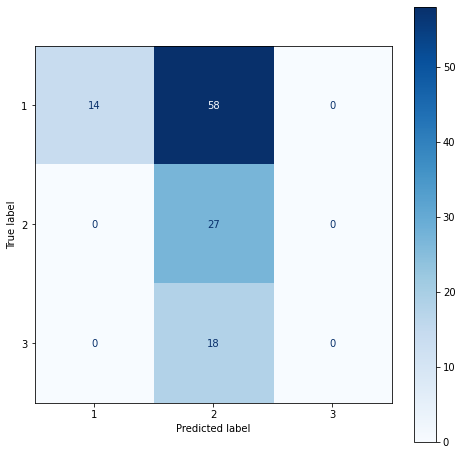

In [95]:
predictions = getUnseenFoldPrediction(kmean_classifier_wine, unseen_fold_features, 0.22)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=wine_dataset["class"].unique())

## Mid Imbalance Wine Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [96]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_mid_imb, labels_mid_imb)

### Seperating Features and Labels

In [97]:
train_features = features_mid_imb.iloc[train_fold_indexes]
train_labels = labels_mid_imb.iloc[train_fold_indexes]

unseen_fold_features = features_mid_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_mid_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

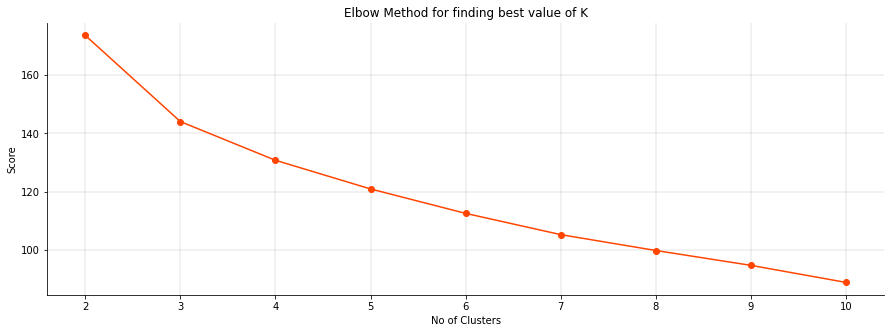

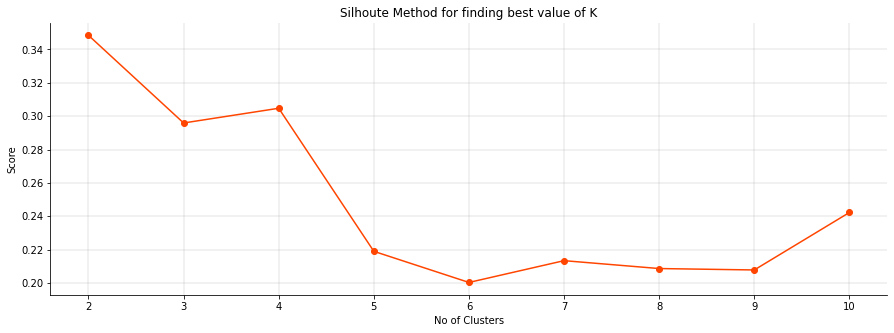

In [98]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [99]:
kmean_classifier_wine = KMeans(n_clusters=5)
wine_cluster_labels = kmean_classifier_wine.fit(train_features)

In [100]:
cluster_details = getpointsClusterInformation(kmean_classifier_wine, train_features, train_labels, distance_threshold=0.22)
cluster_details

[{'K': 1,
  'centroid': array([0.86345907, 0.54423034, 0.78194622, 0.67947712, 0.6368111 ,
         0.72279496, 0.56620864, 0.46702317, 0.56786066, 0.29702363,
         0.57000344, 0.79883987, 0.38151261]),
  'total_classes': array([2.]),
  'minority_class': 2.0,
  'minority_class_count': 8,
  'classifier': None},
 {'K': 2,
  'centroid': array([0.93840235, 0.30754606, 0.73159379, 0.54930365, 0.65212244,
         0.79286118, 0.64827149, 0.40582192, 0.61767238, 0.48282403,
         0.6168389 , 0.79195205, 0.69720727]),
  'total_classes': array([1.]),
  'minority_class': 1.0,
  'minority_class_count': 41,
  'classifier': None},
 {'K': 3,
  'centroid': array([0.82493734, 0.28996422, 0.66369239, 0.67378931, 0.567843  ,
         0.55677397, 0.39075732, 0.56496569, 0.42027248, 0.21771408,
         0.60697341, 0.71371462, 0.28169362]),
  'total_classes': array([2.]),
  'minority_class': 2.0,
  'minority_class_count': 33,
  'classifier': None},
 {'K': 4,
  'centroid': array([0.85813708, 0.46999

### Predicting Classes from Unseen Data fold

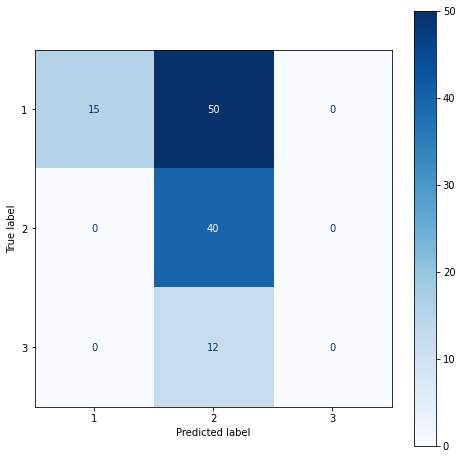

In [101]:
predictions = getUnseenFoldPrediction(kmean_classifier_wine, unseen_fold_features, 0.22)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=wine_dataset["class"].unique())

## High Imbalance Wine Dataset

### Training Mix of Supervised and Unsupervised Model

### Creating KFolds of data

In [102]:
train_fold_indexes, test_fold_indexes,\
unseen_fold_train_indexes, unseen_fold_test_indexes = applyTechniquesOnKFoldsOfData(features_high_imb, labels_high_imb)

### Seperating Features and Labels

In [103]:
train_features = features_high_imb.iloc[train_fold_indexes]
train_labels = labels_high_imb.iloc[train_fold_indexes]

unseen_fold_features = features_high_imb.iloc[unseen_fold_train_indexes]
unseen_fold_labels = labels_high_imb.iloc[unseen_fold_train_indexes]

### Applying Techniques to Find best K

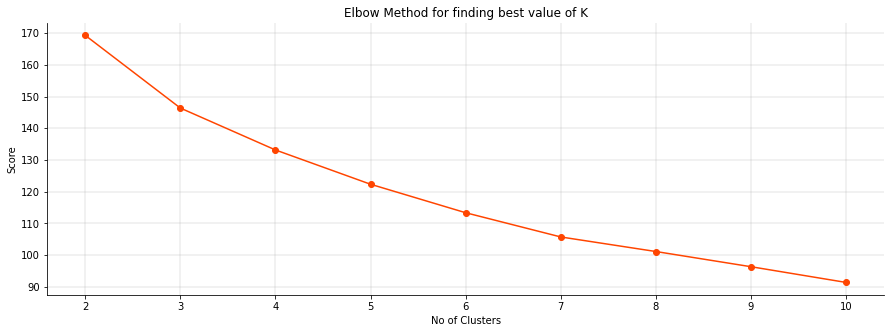

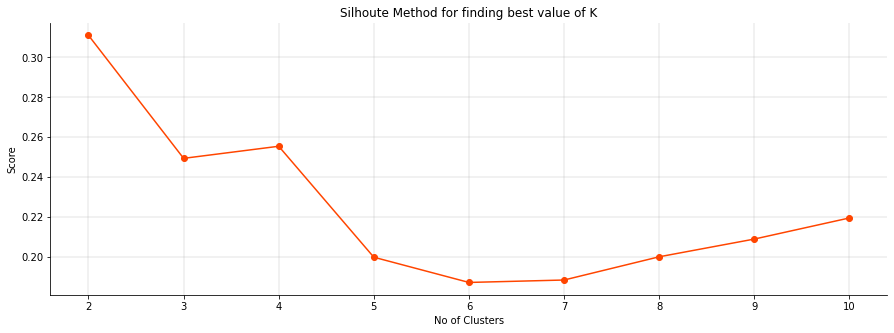

In [104]:
elbowMethodResult(train_features)
avgSilhouteMethodResult(train_features)

### KMeans Clustering

In [105]:
kmean_classifier_wine = KMeans(n_clusters=5)
wine_cluster_labels = kmean_classifier_wine.fit(train_features)

In [106]:
cluster_details = getpointsClusterInformation(kmean_classifier_wine, train_features, train_labels, distance_threshold=0.20)
cluster_details

[{'K': 1,
  'centroid': array([0.8548778 , 0.45631873, 0.7605556 , 0.67578378, 0.62802803,
         0.72164948, 0.56945095, 0.47886978, 0.59136343, 0.29229106,
         0.58542753, 0.77714865, 0.36818211]),
  'total_classes': array([2.]),
  'minority_class': 2.0,
  'minority_class_count': 8,
  'classifier': None},
 {'K': 2,
  'centroid': array([0.82049082, 0.31582027, 0.74299653, 0.70315152, 0.55342312,
         0.49337707, 0.31789549, 0.78273646, 0.37000169, 0.24837296,
         0.64274322, 0.59071212, 0.31324315]),
  'total_classes': array([2.]),
  'minority_class': 2.0,
  'minority_class_count': 17,
  'classifier': None},
 {'K': 3,
  'centroid': array([0.93017406, 0.32275253, 0.75353167, 0.55594555, 0.65633772,
         0.74234769, 0.59710852, 0.43307245, 0.53882867, 0.43957718,
         0.6232653 , 0.79130243, 0.69035268]),
  'total_classes': array([1.]),
  'minority_class': 1.0,
  'minority_class_count': 24,
  'classifier': None},
 {'K': 4,
  'centroid': array([0.82726395, 0.29676

### Predicting Classes from Unseen Data fold

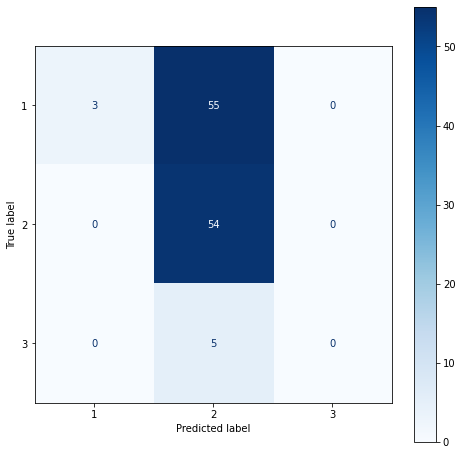

In [107]:
predictions = getUnseenFoldPrediction(kmean_classifier_wine, unseen_fold_features, 0.20)
predictions = getCleanPredictions(predictions)
computeAndPlotConfusionMatrix(unseen_fold_labels, predictions, labels=wine_dataset["class"].unique())